# Training a GDS Pipeline and Making Predictions using Node2Vec

In [2]:
import sys
import os
sys.path.append(os.path.join(os.curdir, "../.."))
# sys.path

from utils import create_projected_graph

In [3]:
from graphdatascience import GraphDataScience
gds = GraphDataScience("bolt://localhost:7687", auth=("neo4j", "admin123"))

## Computing embeddings

In [4]:
projected_graph_object = create_projected_graph(
    gds,
    graph_name="graph-clf-emb-n2v",
    node_spec="MainComponent", 
    relationship_spec={"KNOWS": {"orientation": "UNDIRECTED", "aggregation": "SINGLE"}},
)

Loading:   0%|          | 0/100 [00:00<?, ?%/s]

In [5]:
gds.beta.node2vec.write(projected_graph_object, writeProperty="n2vEmbedding")

nodeCount                                                            36878
nodePropertiesWritten                                                36878
preProcessingMillis                                                      0
computeMillis                                                        85150
writeMillis                                                            935
configuration            {'negativeSamplingExponent': 0.75, 'initialLea...
lossPerIteration                                                     [inf]
Name: 0, dtype: object

## Training Pipeline

In [6]:
projected_graph_object = create_projected_graph(
    gds,
    graph_name="graph-clf-emb",
    node_spec={
        "Person": {
            "label": "MainTrainDownSampled",
            "properties": {
                "isUSCitizen": {"defaultValue": 0},
                "n2vEmbedding": {},
            }
        },
    }, 
    relationship_spec={"KNOWS": {"orientation": "UNDIRECTED", "aggregation": "SINGLE"}},
)

ClientError: Failed to invoke procedure `gds.graph.project`: Caused by: java.lang.IllegalArgumentException: Invalid node projection, one or more labels not found: 'MainTrainDownSampled'

In [ ]:
try:
    pipe = gds.pipeline.get("pipe-clf-emb")
    gds.beta.pipeline.drop(pipe)
except ValueError:
    pass

In [ ]:
pipe, pipe_info = gds.beta.pipeline.nodeClassification.create("pipe-clf-emb")
pipe, pipe_info

In [ ]:
pipe.selectFeatures(["n2vEmbedding"])
pipe

In [ ]:
pipe.addRandomForest(minSplitSize=30, minLeafSize=10)

In [ ]:
#  drop model if already exists
try:
    model = gds.model.get("clf-rf-emb")
    gds.beta.model.drop(model)
except ValueError:
    pass

In [ ]:
model, model_info = pipe.train(
    projected_graph_object,
    modelName="clf-rf-emb",
    targetProperty="isUSCitizen",
    metrics=["ACCURACY", "PRECISION(class=1)", "F1_WEIGHTED", ],
)
model_info

In [ ]:
model_info["modelSelectionStats"]

## Making predictions

In [ ]:
projected_graph_object = create_projected_graph(
    gds,
    graph_name="graph-clf-emb-test",
    node_spec="MainTest", 
    relationship_spec={"KNOWS": {"orientation": "UNDIRECTED", "aggregation": "SINGLE"}},
    nodeProperties=["n2vEmbedding", "isUSCitizen"],
)

In [ ]:
predictions = model.predict_stream(
    projected_graph_object,
    targetNodeLabels=["MainTest"],
    includePredictedProbabilities=True
)
predictions.head()

In [ ]:
# inspect projected graph to find out true class
df_test = gds.graph.nodeProperty.stream(
    projected_graph_object, 
    "isUSCitizen",
)
df_test = df_test.set_index("nodeId")
df_test.head(10)

In [ ]:
predictions = predictions.set_index("nodeId")
df_test["prediction"] = predictions.predictedClass
# we drop the rows in df_test without prediction, actually corresponding to nodes with label MainTrain
# that were excluded from the predictions
df_test = df_test.dropna(subset=["prediction"])
df_test.head()

In [ ]:
from sklearn.metrics import confusion_matrix
mat = confusion_matrix(df_test.propertyValue, df_test.prediction)
mat

In [7]:
import numpy as np
mat = np.array([[1125,  233],
       [  61,  626]])
mat

array([[1125,  233],
       [  61,  626]])

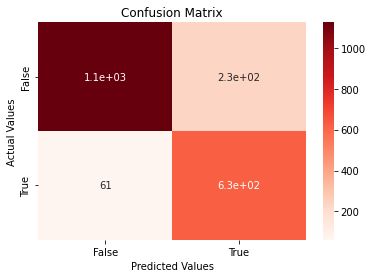

In [9]:
import seaborn as sns
import matplotlib.pyplot as plt

ax = sns.heatmap(mat, annot=True, cmap="Reds")
ax.set_title("Confusion Matrix");
ax.set_xlabel("Predicted Values")
ax.set_ylabel("Actual Values");
ax.xaxis.set_ticklabels(["False", "True"])
ax.yaxis.set_ticklabels(["False", "True"])

plt.savefig("confusion_matrix.png", dpi=500)